<a href="https://colab.research.google.com/github/bbchen33/Insight-project/blob/master/Web_scrape_job_titles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping job titles from Indeed

In [0]:
from bs4 import BeautifulSoup
import requests

A list of job titles that I want to scrape from Indeed (47 unique job titles I hand picked).

In [0]:
job_titles = 'accountant, cook, chief financial officer, civil engineer, editor, research assistant, marketing specialist, salesperson, software developer, data scientist, volunteer, lawyer, graphic designer, ceo, it specialist, technical writer, journalist, medical doctor, pharmacist, translator, qa engineer, administrative assistant, recruiter, hr specialist, secretary, java developer, web developer, foreign language teacher, tour guide, president, mechanical engineer, electrical engineer, driver, professor, copywriter, intern, financial analyst, general manager, procurement specialist, sales manager, insurance agent, medical representative, credit officer, database developer, deputy manager, real estate agent, data entry clerk'

In [0]:
job_titles = job_titles.split(', ')

In [4]:
job_titles[:3]

['accountant', 'cook', 'chief financial officer']

Below is what it looks like when you search for 'chief financial officer' jobs at Indeed. The url will turn the title into 'chief+financial+officer'.

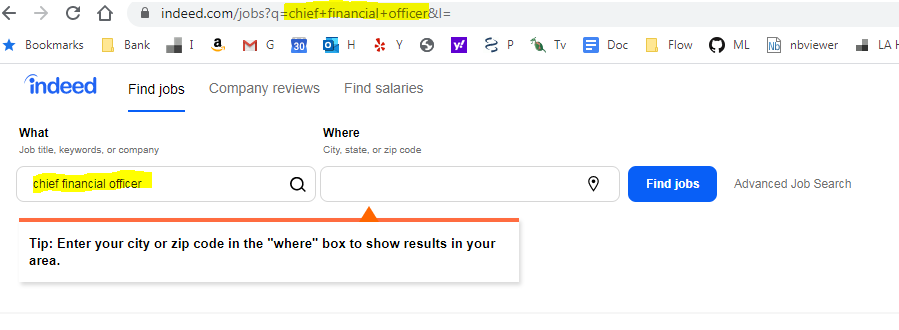

In [0]:
from IPython.display import Image
Image('indeed_search.PNG')

In [0]:
job_titles_for_scrape = []
for job in job_titles:
  text = job.split(' ')
  job_titles_for_scrape.append('+'.join(text))


In [6]:
job_titles_for_scrape[:5] # now the titles are ready to be used

['accountant', 'cook', 'chief+financial+officer', 'civil+engineer', 'editor']

Below shows an example of getting the scraped data and then I'll write function to automate the process.

In [0]:
source = requests.get(f'https://www.indeed.com/jobs?q=accountant&start=10').text
soup = BeautifulSoup(source, 'lxml')

cropped image of where I found the titles in the soup.

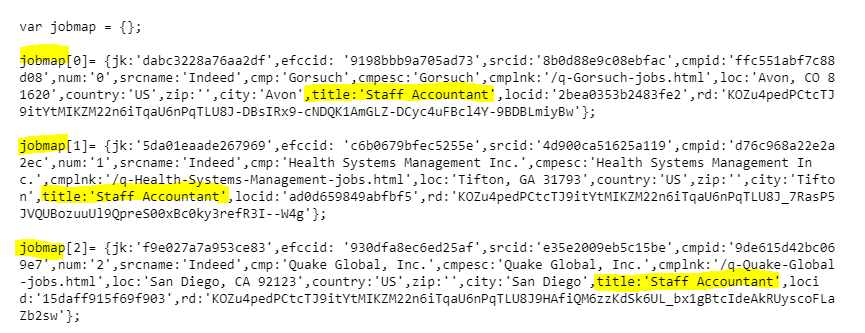

In [0]:
Image('soup_text.PNG')

Find index of 'jobmap' inside soup text.

In [0]:
import re
soup_text = soup.get_text()
all_jobmap = [x.start() for x in re.finditer('jobmap', soup_text)]

Use the jobmap index to find the text and where the title occurs.

In [0]:
first_jobmap = soup_text[all_jobmap[0]:all_jobmap[0]+500]

Find where the keyword 'title' occurs.

In [10]:
first_jobmap.index('title')

300

Show where 'title' occurs and the next 100 characters following it.

In [11]:
first_jobmap[264:264+100]

"GA',country:'US',zip:'',city:'Rome',title:'Senior Accountant',locid:'81483b60ff6f6fd6',rd:'KOZu4pedP"

Now anyone can see the title 'Staff Accountant' and can just split the text with ',' to discard the rest of the information.

In [0]:
import re
def get_titles(soup):
  soup_text = soup.get_text()
  all_jobmap = [x.start() for x in re.finditer('jobmap', soup_text)]
  jobmap_text = []
  for i in range(len(all_jobmap)):
    jobmap_text.append(soup_text[all_jobmap[i]:all_jobmap[i]+500]) #append start of jobmap and 500 more characters after its occurence
  title_index = []
  for titles in jobmap_text:
    try:
      title_index.append(titles.index('title')) #append index where the word 'title' occurs
    except:
      pass
  job_titles = []

  for x,y in zip(title_index, jobmap_text):
    job_title = y[x:x+100]
    job_title = job_title.split(',')[0] #remove the rest of the characters after ','
    job_title = job_title.replace('title:','') 
    job_title = job_title[1:-1]
    job_titles.append(job_title)
  return job_titles

In [0]:
job_dict = {}
for job in job_titles_for_scrape:
  for i in range(10, 70, 10): # start with 10 (page 2), ends with 70 (page 6) see next line
    source = requests.get(f'https://www.indeed.com/jobs?q={job}&start={i}').text #start= is for page number, page 1 is none, page 2 is 10, page 3 is 20 and so on 
    soup = BeautifulSoup(source, 'lxml')
    if job not in job_dict:
      job_dict[job] = get_titles(soup)
    else:
      job_dict[job] += get_titles(soup)

In [14]:
len(job_dict)

47

In [16]:
job_dict['accountant']

['Farm Accountant',
 'Farm Accountant',
 'Senior Accountant',
 'Staff Accountant',
 'Construction Accountant',
 'Staff Accountant',
 'Staff Accountant (accounting degree req) (Dyersbur',
 'Staff Accountant - College Graduate',
 'Senior Accountant',
 'Staff Accountant',
 'Accountant',
 'Staff Accountant',
 'Sr Accountant-USD',
 'Property Accountant',
 'Unemployment Tax Representative-Prince William',
 'Store Accountant',
 'STAFF ACCOUNTANT',
 'Accountant',
 'Staff Accountant',
 'Accountant\\/Financial Analyst--Hospital',
 'Staff Accountant',
 'Staff Accountant',
 'Staff Accountant',
 'Accountant',
 'Farm Accountant',
 'Senior Accountant',
 'Staff Accountant',
 'Accountant',
 'Unemployment Tax Representative-Prince William',
 'Accountant',
 'Staff Accountant',
 'Accountant I',
 'Full Charge Bookkeeper\\/Accountant',
 'Accountant Specialist',
 'Corporate Staff Accountant',
 'Staff Accountant',
 'Cost Accountant',
 'Staff Accountant (accounting degree req) (Dyersbur',
 'Staff Accountant - 

The length of job_dict is the number of job titles I want to scrape. It's 47 so it is correct.

Next, let's make the dictionary into a dataframe. First, we'll need to combine all of the scraped job titles into a list.

In [0]:
collected_job = []
for jobs in job_dict.values():
  for job in jobs:
    collected_job.append(job)

In [18]:
len(collected_job)

5476

In [0]:
import pandas as pd
indeed_df = pd.DataFrame()
indeed_df['various job'] = collected_job

In [0]:
import itertools
official_jobs = []
for job in job_titles_for_scrape:
  for x in itertools.repeat(job, len(job_dict[job])):
    official_jobs.append(x)

In [0]:
indeed_df['official_job'] = official_jobs

In [22]:
indeed_df.head()

,various job,official_job
0,Farm Accountant,accountant
1,Farm Accountant,accountant
2,Senior Accountant,accountant
3,Staff Accountant,accountant
4,Construction Accountant,accountant


Not useful to have the same 'various job' multiple times so dropping them to reduce the file size.

In [0]:
indeed_df = indeed_df.drop_duplicates(subset = 'various job')

In [24]:
len(indeed_df)

1980

In [0]:
indeed_df.to_csv('indeed_jobs_final.txt', sep = '\t', index = False)

In [0]:
from google.colab import files
files.download('indeed_jobs_final.txt')